# Museums in the Pandemic - Text analytics

**Author**: Andrea Ballatore (Birkbeck, University of London)

**Abstract**: TODO

## Setup
This is to check that your environment is set up correctly (it should print 'env ok', ignore warnings).

In [18]:
# Test geospatial libraries
# check environment
import os
print("Conda env:", os.environ['CONDA_DEFAULT_ENV'])
if os.environ['CONDA_DEFAULT_ENV'] != 'mip_v1':
    raise Exception("Set the environment 'mip_v1' on Anaconda. Current environment: " + os.environ['CONDA_DEFAULT_ENV'])

# spatial libraries 
import pandas as pd
import pickle
from termcolor import colored
import sys
import spacy
import numpy as np
#import tensorflow as tf
from bs4 import BeautifulSoup
from bs4.element import Comment
#import torch
import matplotlib.pyplot as plt

# import from `mip` project
print(os.getcwd())
fpath = os.path.abspath('../')
if not fpath in sys.path:
    sys.path.insert(0, fpath)

out_folder = '../../'

from museums import *
from utils import _is_number

print('env ok')

Conda env: mip_v1
/Users/andreab/Dropbox/DRBX_Docs/Work/Projects/github_projects/museums-in-the-pandemic/mip/notebooks
env ok


# Museum text analytics


## Model1: Vectorise text from museum websites

### Connect to DB

In [165]:
# open connection to DB
from db.db import connect_to_postgresql_db

db_conn = connect_to_postgresql_db()
print("DB connected")

DB connected


### Setup spacy NLP

In [7]:
# install language model
!python -m spacy download en_core_web_sm
# Note: if this cell does not work, run the same command 
#       without "!" in the Anaconda terminal

     |████████████████████████████████| 12.0 MB 5.2 MB/s eta 0:00:01
  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.3.1-py3-none-any.whl size=12047106 sha256=6e736cfbfe09463c336696b4717b7863a88b5d6766fe3bbf830fc9b77c861a42
  Stored in directory: /private/var/folders/84/_52b_kt95ybgx9pwl31_nvqh0000gn/T/pip-ephem-wheel-cache-dcoj7ilh/wheels/ee/4d/f7/563214122be1540b5f9197b52cb3ddb9c4a8070808b22d5a84
Successfully built en-core-web-sm
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [5]:
# set up the spacy environment
import spacy
from spacy import displacy
from collections import Counter
spacy.prefer_gpu()
# load language model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [7]:
# Spacy stopwords
#all_stopwords = nlp.Defaults.stop_words

In [8]:
# get text from websites

from analytics.an_websites import get_attribute_for_webpage_url

session_id = '20210420'
test_urls = ['https://www.britishmuseum.org/']
attrib_name = 'all_text' # 'title'

for url in test_urls:
    print(url)
    res = get_attribute_for_webpage_url(url, session_id, attrib_name, db_conn)
    if not res: continue
    print(res)
    blocks = res.split("\n")
    print("LEN", len(blocks))
    print(blocks)

https://www.britishmuseum.org/
Skip to main content Please enable JavaScript in your web browser to get the best experience. We use cookies to make our website work more efficiently, to provide you with more personalised services or advertising to you, and to analyse traffic on our website. For more information on how we use cookies and how to manage cookies, please follow the 'Read more' link, otherwise select 'Accept and close'. Read more about our cookie policy Accept and close the cookie policy Menu Main navigation Visit Toggle Visit submenu Back
to previous menu —
Visit —
Visit —
Family visits —
Group visits —
Audio guide —
Out-of-hours tours —
Tours and talks —
Object trails —
Accessibility —
Food and drink —
Late opening on Fridays —
Museum map Exhibitions and events Collection Toggle Collection submenu Back
to previous menu —
Collection —
Collection —
Collection online —
Galleries —
Blog —
Audio tour highlights —
The British Museum podcast Learn Toggle Learn submenu Back
to pre

### Preprocess text

In [9]:
MOVED

def spacy_extract_tokens(text):
    """ 
    @returns data frame with tokens with POS, lemma, stop words
    """
    tokens_df = pd.DataFrame()
    text_sentences = nlp(text)
    sent_id = 0
    # segment sentences
    for sentence in text_sentences.sents:
        sent_id += 1
        # for each sentence
        snt_text = sentence.text
        pos_df = pd.DataFrame()
        print(colored('>', 'red'), snt_text)
        for token in sentence:
            # for each token
            tokens_df = tokens_df.append(pd.DataFrame(
                {"sentence_id": sent_id, "token":token.text, 'lemma':token.lemma_,
                 "pos_tag":token.pos_, 'is_stop': token.is_stop}, 
                index=[0]), ignore_index=True)
    return tokens_df

test_texts = ["""We need your support Your support is vital and helps the Museum to share the collection with the world. Make a donation What's online... The flowers of Mary Delany 233 years after her death, Delany's detailed floral collages still delight and inspire. Take a closer look at her work in the collection. How to explore the British Museum from home Whether it's a behind-the-scenes podcast or a closer look at our galleries, here are 10 ways to explore the Museum while we're closed. British histories beyond 'Bridgerton' Inspired by the hit Netflix show, watch a panel discussion exploring the reality behind the fantasy of 'Bridgerton'. Discover the Maya World Take a trip to Mexico and explore a wealth of content from the Maya Research Project, including stories, videos and 3D explorations."""]

for tt in test_texts:
    print(tt)
    print("")
    df = spacy_extract_tokens(tt)
    print("Tokens N =",len(df))
    fout = out_folder+'tmp/museum_text_tokens.csv'
    df.to_csv(fout, index=False)
    print("See tokens in",fout)


We need your support Your support is vital and helps the Museum to share the collection with the world. Make a donation What's online... The flowers of Mary Delany 233 years after her death, Delany's detailed floral collages still delight and inspire. Take a closer look at her work in the collection. How to explore the British Museum from home Whether it's a behind-the-scenes podcast or a closer look at our galleries, here are 10 ways to explore the Museum while we're closed. British histories beyond 'Bridgerton' Inspired by the hit Netflix show, watch a panel discussion exploring the reality behind the fantasy of 'Bridgerton'. Discover the Maya World Take a trip to Mexico and explore a wealth of content from the Maya Research Project, including stories, videos and 3D explorations.

> We need your support Your support is vital and helps the Museum to share the collection with the world.
> Make a donation
> What's online...
> The flowers of Mary Delany 233 years after her death, Delany'

### Annotations

In [3]:
# extract tokens from annotations
from analytics.text_models import get_indicator_annotations

indic_df, ann_df = get_indicator_annotations("../../")
ann_df

,text_phrases,indicator_code,indicator_attributes,notes,example_id
0,Closed now,closed_cur,NaN,NaN,0
1,closed to members of the public until further ...,closed_cur,NaN,NaN,1
2,closed until further notice,closed_cur,NaN,NaN,2
3,closed until Spring 2021,closed_cur,NaN,NaN,3
4,Closed: Until further notice,closed_cur,NaN,NaN,4
...,...,...,...,...,...
146,Bailiffgate is now closed due to Covid.,closed_cur,NaN,NaN,146
147,Visit our online shop,open_onlineshop,NaN,NaN,147
148,The new stunning Felton Group online exhibitio...,online_exhib,_description,NaN,148
149,Stay up to date with what's happening at Baili...,online_engag,NaN,NaN,149


In [4]:
ann_tokens_df = pd.DataFrame()

for index, row in ann_df.iterrows():
    txt = str(row['text_phrases']).strip()
    df = spacy_extract_tokens(txt)
    #print(df)
    df['example_id'] = row['example_id']
    df['indicator_code'] = row['indicator_code']
    ann_tokens_df = pd.concat([ann_tokens_df, df])

# output annotations tokens
fout = out_folder+'tmp/test_annotations_tokens.csv'
ann_tokens_df.to_csv(fout, index=False)
print(fout)

NameError: name 'spacy_extract_tokens' is not defined

### Indicator matching

This code identifies indicators in raw text

In [6]:
ftext = out_folder+'tmp/museum_text_tokens.csv'
text_df = pd.read_csv(ftext)
print(len(text_df))
text_df.sample(10)

findic = out_folder+'tmp/test_annotations_tokens.csv'
ann_df = pd.read_csv(findic)
print(len(ann_df))

ann_df

155
1857


,sentence_id,token,lemma,pos_tag,is_stop,example_id,indicator_code
0,1,Closed,close,VERB,False,0,closed_cur
1,1,now,now,ADV,True,0,closed_cur
2,1,closed,close,VERB,False,1,closed_cur
3,1,to,to,ADP,True,1,closed_cur
4,1,members,member,NOUN,False,1,closed_cur
...,...,...,...,...,...,...,...
1852,1,'ve,have,AUX,True,150,made_covid_safe
1853,1,made,make,VERB,True,150,made_covid_safe
1854,1,your,-PRON-,DET,True,150,made_covid_safe
1855,1,visit,visit,NOUN,False,150,made_covid_safe


Options for matches
- Case sensitive/insens (lower case) 
- match lemma
- match token
- stopwords or not

In [9]:
print(text_df.columns)
print(ann_df.columns)

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


In [41]:
MOVED

def _filter_tokens(df, keep_stopwords=True):
    """ Remove tokens that do not carry semantic content """
    
    if not keep_stopwords:
        df = df[~df['is_stop']]
    
    filt_df = df[~df['pos_tag'].isin(['DET','ADP','PRON','PUNCT'])]
    return filt_df


def _match_tokens(musetxt_df, annot_df, case_sensitive, keep_stopwords):
    """
    TODO
    """
    assert len(musetxt_df)>=0
    assert len(annot_df)>=0
    # set up options
    prefix = 'var_'
    suffix = ''
    if case_sensitive: suffix = '_csens'
    else: suffix = '_cinsens'
    if case_sensitive: suffix = '_csens'
    else: suffix = '_cinsens'
        
    if keep_stopwords: suffix += '_wstopw'
    else: suffix += '_nostopw'
        
    # filter tokens
    filt_text_df = _filter_tokens(musetxt_df, keep_stopwords)
    filt_ann_df = _filter_tokens(annot_df, keep_stopwords)
    
    # case in/sensitive
    if not case_sensitive:
        # make lower case
        filt_text_df.loc[:, 'lemma'] = filt_text_df.loc[:, 'lemma'].str.lower()
        filt_text_df.loc[:, 'token'] = filt_text_df.loc[:, 'token'].str.lower()
        filt_ann_df.loc[:, 'lemma'] = filt_ann_df.loc[:, 'lemma'].str.lower()
        filt_ann_df.loc[:, 'token'] = filt_ann_df.loc[:, 'token'].str.lower()
        
    # generate match variables for each example/text pair
    lemmas_df = filt_text_df.merge(filt_ann_df, on=['lemma'])
    tokens_df = filt_text_df.merge(filt_ann_df, on=['token'])
    lemmas_m = " ".join(lemmas_df['lemma'].tolist())
    tokens_m = " ".join(tokens_df['token'].tolist())
    vars_d = {
        prefix+'lemmas_n'+suffix:len(lemmas_df), 
        prefix+'lemmas_m'+suffix: lemmas_m, 
        prefix+'tokens_n'+suffix:len(tokens_df),
        prefix+'tokens_m'+suffix: tokens_m
    }
    return vars_d


def match_musetext_indicators(muse_id, txt_df, annot_df):
    """ Main match loop between set of sentences and set of annotations """
    assert muse_id
    assert len(txt_df) >= 0
    assert len(annot_df) >= 0
    
    df = pd.DataFrame()
    
    for sentence_name, txt_sent_df in txt_df.groupby('sentence_id'):
        #print(txt_sent_df)
        for ann_name, ann_example_df in annot_df.groupby('example_id'):
            #print(ann_example_df)
            tmpdf = _match_musetext_vs_indicator_example(muse_id, txt_sent_df, ann_example_df)
            df = df.append(tmpdf)
    
    df.reset_index()
    return df

    
def _match_musetext_vs_indicator_example(muse_id, txt_df, annot_df):
    """ 
    Match single text sentence with single annotation example
    """
    #print("_match_musetext_vs_indicator_example")
    # get txt sentence id
    sentence_id = txt_df['sentence_id'].tolist()[0]
    # get annotation example id and code
    example_id = annot_df['example_id'].tolist()[0]
    indicator_code = annot_df['indicator_code'].tolist()[0]
    
    d = {}
    for cs in [True, False]:
        for sw in [True, False]:
            #print('debug 2')
            match_vars_d = _match_tokens(txt_df, annot_df, cs, sw)
            d.update(match_vars_d)
    
    # sum all values
    all_nums = [x for x in d.values() if _is_number(x)]
    d['all_sum_n'] = sum(all_nums)
    
    # base dictionary
    res_d = {'muse_id':muse_id, 
             'muse_text_sentence_id': [sentence_id], 
             'annotation_example_id':[example_id],
             'muse_text_sentence_len': len(txt_df), 
             'annotation_example_len': len(annot_df)}
    res_d.update(d)
    
    res_df = pd.DataFrame(data=res_d)
    assert len(res_df)>0
    return res_df

In [42]:
# call test match 
muse_id = 'test.123'
df = match_musetext_indicators(muse_id, text_df, ann_df)

print(len(df))
fout = out_folder + 'tmp/all_matches_test.csv'
df.to_csv(fout, index=False)

1510


In [71]:
OLD
# iterate over each group
#for group_name, df_group in df1_grouped:
    
    # match lemmas
    matched_df = filt_text_df.merge(filt_ann_df, on=target_col, suffixes=('_txt', '_ann'))
    print(matched_df.columns)
    matched_df.to_csv(out_folder+'tmp/indic_match_counts_all.csv', index=False)

    df = matched_df.groupby(['sentence_id_txt','example_id','indicator_code']).size().reset_index(name='n_match_'+target_col)
    print(df)
    df.to_csv(out_folder+'tmp/indic_match_counts_counts.csv', index=False)
    #return df
    
mdf = match_tokens(text_df, ann_df, 'lemma')
tdf = match_tokens(text_df, ann_df, 'token')
all_matches_df = mdf.merge(tdf, on=['sentence_id_txt','example_id','indicator_code'], how='outer')

all_matches_df['n_match_lemma'] = all_matches_df['n_match_lemma'].fillna(0)
all_matches_df['n_match_token'] = all_matches_df['n_match_token'].fillna(0)
all_matches_df

Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop'], dtype='object')
Index(['sentence_id', 'token', 'lemma', 'pos_tag', 'is_stop', 'example_id',
       'indicator_code'],
      dtype='object')


NameError: name 'df1_grouped' is not defined

## Text analysis from DB

Analyse text stats from DB
### Load data

In [111]:
assert db_conn

t = "analytics.text_indic_ann_matches"
sql = """select count(distinct muse_id) from {} t;""".format(t)
print(sql)
df = pd.read_sql(sql, db_conn)
df

select count(distinct muse_id) from analytics.text_indic_ann_matches t;


,count
0,357


In [112]:
mus_df = get_museums_sample_urls(out_folder)

museums urls: ../../data/museums/correct_url_stratified_sample_401.tsv
get_museums_w_web_urls Museums=400 URLs=400


In [113]:
sample_df = mus_df.sample(10)
muse_ids = sample_df.muse_id.tolist()
muse_ids = str(muse_ids).replace('[','(').replace(']',')')
#print(muse_ids)
sql = """select * from {} t where muse_id in {};""".format(t, muse_ids)
print(sql)
df = pd.read_sql(sql, db_conn)

fn = out_folder + 'tmp/match_samples.tsv'
print(df.keep_stopwords.describe())
df.to_csv(fn, sep='\t', index=False)
df.describe().transpose()

select * from analytics.text_indic_ann_matches t where muse_id in ('mm.domus.WM033', 'mm.hha.074', 'mm.domus.SW094', 'mm.domus.WA098', 'mm.musa.149', 'mm.ace.1160', 'mm.domus.SW156', 'mm.New.74', 'domus.NE043', 'mm.hha.098');
count     20744
unique        1
top        True
freq      20744
Name: keep_stopwords, dtype: object


,count,mean,std,min,25%,50%,75%,max
lemma_n,20744.0,1.105958,0.483299,0.0,1.00000,1.00000,1.00000,7.0
lemma_n_wdupl,20744.0,1.224595,0.642191,0.0,1.00000,1.00000,1.00000,8.0
token_n,20744.0,1.042277,0.506427,0.0,1.00000,1.00000,1.00000,6.0
token_n_wdupl,20744.0,1.165204,0.666874,0.0,1.00000,1.00000,1.00000,7.0
sent_len,20744.0,12.421086,7.639868,1.0,7.00000,11.00000,16.00000,58.0
example_len,20744.0,6.582675,3.193982,1.0,4.00000,6.00000,8.00000,17.0
ann_overlap_lemma,20744.0,0.206302,0.138085,0.0,0.12500,0.16667,0.25000,1.0
ann_overlap_token,20744.0,0.197095,0.143119,0.0,0.11111,0.16667,0.25000,1.0
txt_overlap_lemma,20744.0,0.131726,0.129892,0.0,0.06250,0.09091,0.16667,1.0
txt_overlap_token,20744.0,0.132466,0.148895,0.0,0.05556,0.09091,0.15385,1.0


In [166]:
# get all matches (SLOW)
sql = """select example_id, indicator_code, token_n, lemma_n, ann_overlap_lemma, ann_overlap_token, example_len
    from analytics.text_indic_ann_matches t where keep_stopwords;"""
df = pd.read_sql(sql, db_conn)
print(len(df))

883265


In [182]:
# generate derived fields
df["lemmatoken_n"] = df[["lemma_n", "token_n"]].max(axis=1)
df["lemmatoken_n"].describe()

df["ann_overlap_tokenlemma"] = df["lemmatoken_n"]/df['example_len']

assert df.ann_overlap_tokenlemma.between(0,1).all(),'incorrect range'

df.sample(20)

,example_id,indicator_code,token_n,lemma_n,ann_overlap_lemma,ann_overlap_token,example_len,lemmatoken_n,ann_overlap_tokenlemma
715249,ann_ex_00131,lang_difficulty,1.0,1.0,0.11111,0.11111,9,1.0,0.111111
264791,ann_ex_00178,online_engag,0.0,1.0,0.11111,0.00000,9,1.0,0.111111
36136,ann_ex_00229,reopen_intent,1.0,1.0,0.25000,0.25000,4,1.0,0.250000
846351,ann_ex_00183,online_event,1.0,1.0,0.50000,0.50000,2,1.0,0.500000
778401,ann_ex_00233,reopen_intent,1.0,1.0,0.25000,0.25000,4,1.0,0.250000
440465,ann_ex_00164,lang_difficulty,1.0,1.0,0.12500,0.12500,8,1.0,0.125000
785892,ann_ex_00124,funding_gov_emer,1.0,1.0,0.16667,0.16667,6,1.0,0.166667
875964,ann_ex_00159,lang_difficulty,1.0,1.0,0.20000,0.20000,5,1.0,0.200000
302678,ann_ex_00009,closed_cur,1.0,1.0,0.50000,0.50000,2,1.0,0.500000
478286,ann_ex_00280,staff_working,1.0,1.0,0.25000,0.25000,4,1.0,0.250000


## Distributions

In [117]:
# descriptive stats of all values
#df.groupby('keep_stopwords').describe().transpose()
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
token_n,883265.0,1.030551,0.497137,0.0,1.00000,1.00000,1.00,8.0
lemma_n,883265.0,1.124612,0.441228,0.0,1.00000,1.00000,1.00,8.0
ann_overlap_lemma,883265.0,0.203200,0.124995,0.0,0.12500,0.16667,0.25,1.0
ann_overlap_token,883265.0,0.186740,0.131619,0.0,0.11111,0.16667,0.25,1.0


In [151]:
# describe indicators
indic_df = round(df['indicator_code'].value_counts(normalize=True)*100,1)
indic_df.columns = ['n_matches']
indic_df.to_csv(out_folder+'tmp/indicator_stats.csv')
print('N matches =',len(df))
indic_df

N matches = 883265


funding_fundraise      18.5
reopen_intent          13.8
closed_cur             12.7
lang_difficulty        12.6
staff_working           6.2
open_onlineshop         4.8
funding_gov_emer        3.8
online_engag            3.7
staff_hiring            3.2
finance_health          2.7
funding_other_emer      2.6
reopen_plan             2.5
funding_did_not_get     2.3
closed_perm             2.0
online_event            1.9
closed_indef            1.6
open_cur                1.5
online_exhib            1.2
project_postpone        1.1
made_covid_safe         0.6
open_cafe               0.4
open_garden             0.3
staff_restruct          0.1
Name: indicator_code, dtype: float64

                 count      mean       std  min  25%  50%  75%  max
token_n       883265.0  1.030551  0.497137  0.0  1.0  1.0  1.0  8.0
lemma_n       883265.0  1.124612  0.441228  0.0  1.0  1.0  1.0  8.0
lemmatoken_n  883265.0  1.146149  0.420205  1.0  1.0  1.0  1.0  8.0


array([[<AxesSubplot:title={'center':'token_n'}>,
        <AxesSubplot:title={'center':'lemma_n'}>],
       [<AxesSubplot:title={'center':'lemmatoken_n'}>, <AxesSubplot:>]],
      dtype=object)

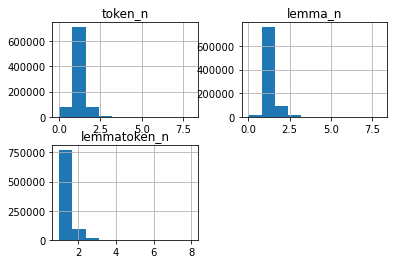

In [197]:
# distribution token_n and lemma_n
print(df[['token_n','lemma_n','lemmatoken_n']].describe().transpose())
df[['token_n','lemma_n','lemmatoken_n']].hist(bins=10)

array([[<AxesSubplot:title={'center':'lemmatoken_n'}>]], dtype=object)

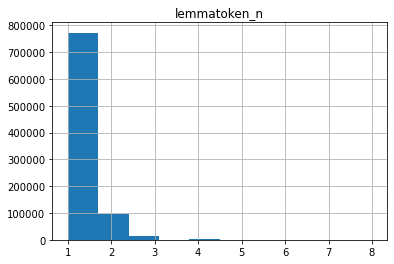

In [196]:
df[['lemmatoken_n']].hist(bins=10)

             lemma_n
count  107526.000000
mean        2.167718
std         0.468068
min         2.000000
25%         2.000000
50%         2.000000
75%         2.000000
max         8.000000


array([[<AxesSubplot:title={'center':'lemma_n'}>]], dtype=object)

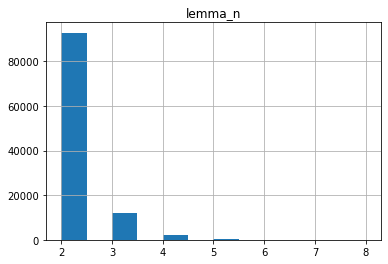

In [198]:
# exclude one match
print(df[['lemma_n']][df.lemma_n > 1].describe())
df[['lemma_n']][df.lemma_n > 1].hist(bins=12)

                           count      mean       std       min      25%  \
ann_overlap_token       883265.0  0.186740  0.131619  0.000000  0.11111   
ann_overlap_lemma       883265.0  0.203200  0.124995  0.000000  0.12500   
ann_overlap_tokenlemma  883265.0  0.209669  0.127575  0.058824  0.12500   

                             50%   75%  max  
ann_overlap_token       0.166670  0.25  1.0  
ann_overlap_lemma       0.166670  0.25  1.0  
ann_overlap_tokenlemma  0.166667  0.25  1.0  


array([[<AxesSubplot:title={'center':'ann_overlap_tokenlemma'}>]],
      dtype=object)

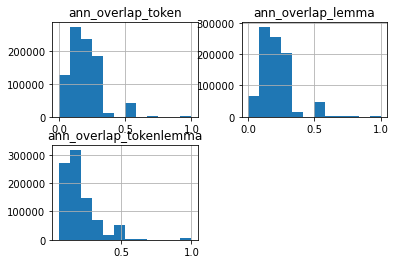

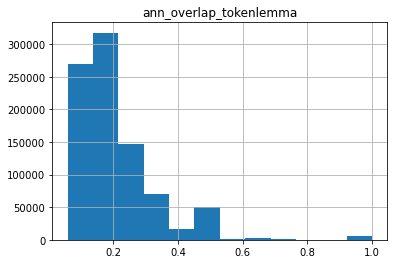

In [204]:
# show hist of overlaps
print(df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma']].describe().transpose())
df[['ann_overlap_token','ann_overlap_lemma','ann_overlap_tokenlemma']].hist(bins=12)

df[['ann_overlap_tokenlemma']].hist(bins=12)

count    883265.000000
mean          6.751379
std           3.198704
min           1.000000
25%           4.000000
50%           6.000000
75%           8.000000
max          17.000000
Name: example_len, dtype: float64
matches with annotations > 1: 880779


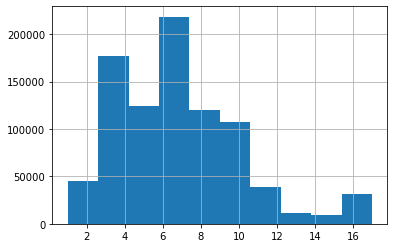

In [202]:
# show length of annotations
print(df['example_len'].describe())
df['example_len'].hist(bins=10)

# filter annotations that are too short: valid df
ldf = df[df['example_len']>1]
print('matches with annotations > 1:', len(ldf))

In [172]:
# count number of examples
indic_df = df[['indicator_code','example_id']].groupby(['indicator_code']).describe()
indic_df = indic_df.sort_values(('example_id', 'unique'), ascending=False)
indic_df

example_id                            
                         count unique           top   freq
indicator_code                                            
funding_fundraise       163824     52  ann_ex_00102   6981
reopen_intent           121752     42  ann_ex_00256   5979
lang_difficulty         110903     39  ann_ex_00163   7626
closed_cur              112422     38  ann_ex_00029   7942
funding_gov_emer         33678     13  ann_ex_00121   6022
online_engag             32445     12  ann_ex_00176   6967
open_onlineshop          42028     11  ann_ex_00205   6593
staff_working            55064     11  ann_ex_00275   6886
online_event             16575      9  ann_ex_00190   3871
staff_hiring             28282      8  ann_ex_00268   6396
funding_did_not_get      20342      7  ann_ex_00055   6001
online_exhib             10211      7  ann_ex_00196   4406
closed_indef             14219      6  ann_ex_00042   3908
finance_health           23678      6  ann_ex_00054   6519
closed_perm              17586      5  ann_ex_00048   5185
funding_other_emer       23012      4  ann_ex_00130  10540
reopen_plan              21967      4  ann_ex_00261   6252
open_cur                 13590      3  ann_ex_00202   9380
project_postpone          9880      3  ann_ex_00215   6015
made_covid_safe           5184      1  ann_ex_00170   5184
open_cafe                 3577      1  ann_ex_00199   3577
open_garden               2561      1  ann_ex_00203   2561
staff_restruct             485      1  ann_ex_00271    485

In [201]:
#TODO choose sample for manual annotation of matches based on 
df['ann_overlap_tokenlemma']
pd.qcut(df['ann_overlap_tokenlemma'], q=4)


0             (0.25, 1.0]
1             (0.25, 1.0]
2             (0.25, 1.0]
3             (0.25, 1.0]
4             (0.25, 1.0]
               ...       
883260    (0.0578, 0.125]
883261     (0.125, 0.167]
883262      (0.167, 0.25]
883263        (0.25, 1.0]
883264        (0.25, 1.0]
Name: ann_overlap_tokenlemma, Length: 883265, dtype: category
Categories (4, interval[float64]): [(0.0578, 0.125] < (0.125, 0.167] < (0.167, 0.25] < (0.25, 1.0]]

In [81]:
OLD
# ann_overlap_lemma, ann_overlap_token
def get_quartiles_db(col_name, table_name, db_conn):
    sql = """select
          percentile_disc(0.0) within group (order by {}) as q0,
          percentile_disc(0.25) within group (order by {}) as q025,
          percentile_disc(0.5) within group (order by {}) as q05,
          percentile_disc(0.75) within group (order by {}) as q075,
          percentile_disc(0.85) within group (order by {}) as q085,
          percentile_disc(0.9) within group (order by {}) as q09,
          percentile_disc(1.0) within group (order by {}) as q1
        from {} t;""".format(col_name,col_name,col_name,col_name,col_name,
                             col_name,col_name,table_name)
    df = pd.read_sql(sql, db_conn)
    df['column'] = col_name
    return df

df = pd.DataFrame()
for col in ['ann_overlap_lemma','ann_overlap_token']:
    df = pd.concat(df, get_quartiles_db(col, 'analytics.text_indic_ann_matches', db_conn))
df

NameError: name 'old' is not defined

End of notebook